In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Import dataset

In [2]:
data_train = pd.read_csv('fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape)
print('Testing', x_test.shape)

Training (42000, 28, 28, 1)
Testing (18000, 28, 28, 1)


# Reorginize the groups

In [3]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4182, 4241, 4243, 4227, 4155, 4173, 4210, 4146, 4239, 4184]
test groups: [1818, 1759, 1757, 1773, 1845, 1827, 1790, 1854, 1761, 1816]


In [4]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

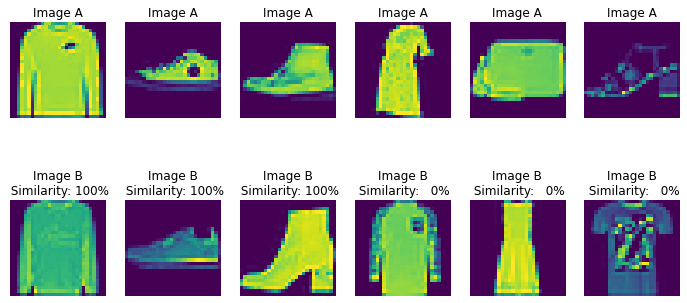

In [5]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

# AlexNet Model

In [21]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

image_shape = (28,28,1)

img_in = Input(shape=x_train.shape[1:])
n_layer = img_in
n_layer = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation= 'relu', input_shape= image_shape)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(4096, activation='relu')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = Dense(4096, activation='relu')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = Dense(10, activation='softmax')(n_layer)

feature_model = Model(inputs=[img_in], outputs=[n_layer])
feature_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_22 (Bat  (None, 5, 5, 96)         384       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 3, 3, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 3, 3, 256)         614656    
                                                                 
 batch_normalization_23 (Bat  (None, 3, 3, 256)        1024

# Siamese Model

In [7]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 10)          21604426    ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['FeatureGeneratio

In [8]:
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
similarity_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'mae'])

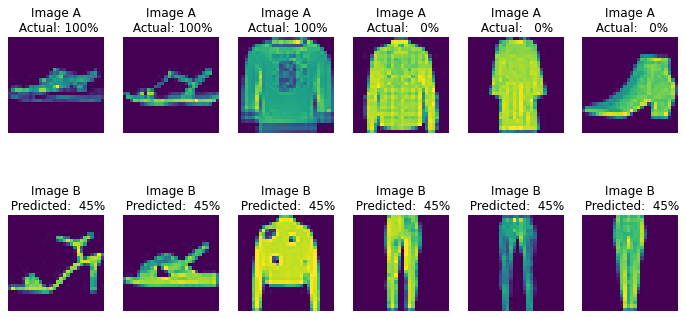

In [9]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,
        m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
    # a completely untrained model
_ = show_model_output()

In [10]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 [==============================] - 221s 440ms/step - loss: 0.5446 - accuracy: 0.7203 - mae: 0.3761 - val_loss: 0.4825 - val_accuracy: 0.7559 - val_mae: 0.3280
Epoch 2/10
500/500 [==============================] - 238s 476ms/step - loss: 0.4951 - accuracy: 0.7469 - mae: 0.3379 - val_loss: 0.4820 - val_accuracy: 0.7588 - val_mae: 0.3229
Epoch 3/10
500/500 [==============================] - 238s 476ms/step - loss: 0.4824 - accuracy: 0.7549 - mae: 0.3294 - val_loss: 0.4640 - val_accuracy: 0.7769 - val_mae: 0.3156
Epoch 4/10
500/500 [==============================] - 221s 443ms/step - loss: 0.4539 - accuracy: 0.7722 - mae: 0.3070 - val_loss: 0.4254 - val_accuracy: 0.7915 - val_mae: 0.2882
Epoch 5/10
500/500 [==============================] - 217s 435ms/step - loss: 0.4340 - accuracy: 0.7852 - mae: 0.2919 - val_loss: 0.4298 - val_accuracy: 0.7891 - val_mae: 0.2823
Epoch 6/10
500/500 [==============================] - 221s 442ms/step - loss: 0.4231 - accuracy: 0.7917 - mae:

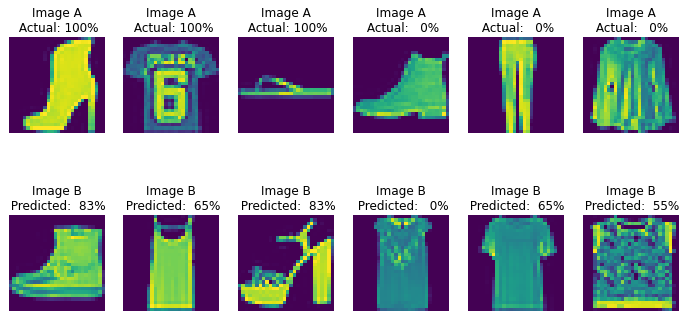

In [11]:
_ = show_model_output()

# Vizualization with t-SNE

In [12]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

141/141 [==============================] - 9s 61ms/step


In [13]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

C:\Users\Iryna.Dosiak\PycharmProjects\ComputerVision\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.045s...
[t-SNE] Computed neighbors for 18000 samples in 0.503s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

C:\Users\Iryna.Dosiak\PycharmProjects\ComputerVision\venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 86.5272217, gradient norm = 0.0189031 (50 iterations in 3.030s)
[t-SNE] Iteration 100: error = 70.1548615, gradient norm = 0.0037590 (50 iterations in 2.979s)
[t-SNE] Iteration 150: error = 64.3531036, gradient norm = 0.0022987 (50 iterations in 2.912s)
[t-SNE] Iteration 200: error = 61.0398941, gradient norm = 0.0017869 (50 iterations in 3.647s)
[t-SNE] Iteration 250: error = 58.8232040, gradient norm = 0.0014535 (50 iterations in 3.615s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.823204
[t-SNE] Iteration 300: error = 2.0144119, gradient norm = 0.0010642 (50 iterations in 3.548s)
[t-SNE] Iteration 350: error = 1.5159138, gradient norm = 0.0006742 (50 iterations in 3.565s)
[t-SNE] Iteration 400: error = 1.1295266, gradient norm = 0.0004650 (50 iterations in 3.555s)
[t-SNE] Iteration 450: error = 0.8517622, gradient norm = 0.0003405 (50 iterations in 3.536s)
[t-SNE] Iteration 500: error = 0.6488407, gradient norm = 0.0002628 (50 

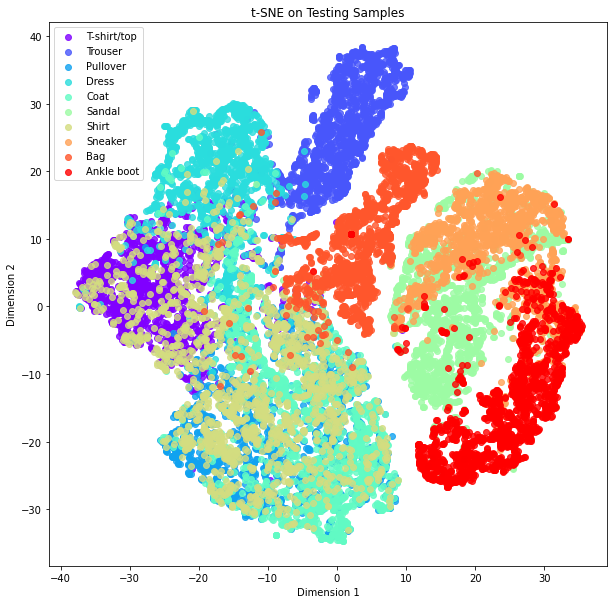

In [17]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'] 
colors = plt.cm.rainbow(np.linspace(0, 1, 10)) 
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],  tsne_features[np.where(y_test == c_group), 1],  marker='o', 
              color=c_color, 
              linewidth=1, 
              alpha=0.8, 
              label=c_label) 
plt.xlabel('Dimension 1') 
plt.ylabel('Dimension 2') 
plt.title('t-SNE on Testing Samples') 
plt.legend(loc='best')  
plt.show(block=False)
